## 0. 필요 라이브러리 불러오기

In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, GAE, Node2Vec, SAGEConv
from torch_geometric.utils import to_undirected, negative_sampling
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import NeighborLoader

from decimal import Decimal, getcontext
from datetime import datetime, timezone
from collections import defaultdict, Counter
from joblib import dump, load

## 1. 데이터 이해 및 전처리

* **CSV 파일 확인**: 이미 `train.csv`, `test.csv`, `edge_index.csv`를 준비했다고 하셨으니, 우선 각 파일에 어떤 컬럼이 있고 어떤 의미인지 정확히 정리하세요.

  * `train.csv`: 노드 ID, feature, label
  * `test.csv`: 노드 ID, feature (라벨 없음)
  * `edge_index.csv`: source 노드, target 노드
* **고민할 점**:

  * 노드 feature가 어떤 타입인지(숫자형/범주형/텍스트 임베딩 등).
  * 라벨이 몇 개의 클래스인지(이진/다중 분류).
  * 엣지가 directed인지 undirected인지.

In [67]:
# 데이터불러오기
raw_train_df = pd.concat([pd.read_csv('train (1-1).csv'), pd.read_csv('train (1-2).csv')], ignore_index=True, axis=0, copy=False, sort=False, verify_integrity=True)
raw_test_df = pd.read_csv('test (1).csv')
raw_edge_index_df = pd.read_csv('edge_index (1).csv').drop('Unnamed: 0', axis=1, inplace=True)

In [68]:
raw_train_df.head()

,id,target,767,766,765,764,763,762,761,760,...,9,8,7,6,5,4,3,2,1,0
0,1,0,-0.027923,0.044652,0.024014,-0.009848,-0.261522,0.256826,-0.050686,-0.086738,...,0.787836,-0.288956,0.556196,-0.580039,-0.066076,-0.403333,-0.306235,0.129879,-0.305108,1.829782
1,2,0,-0.027923,0.044652,0.024014,-0.009848,-0.261522,0.256826,-0.050686,-0.086738,...,0.787836,-0.288956,0.556196,-0.580039,-0.066076,-0.403333,-0.306235,0.129879,-0.305108,1.829782
2,4,0,-0.027923,0.044652,0.024014,-0.009848,-0.261522,0.256826,-0.050686,-0.086738,...,0.787836,-0.288956,0.556196,-0.580039,-0.066076,-0.403333,-0.306235,0.129879,-0.305108,1.829782
3,5,0,-0.027923,0.044652,0.024014,-0.009848,-0.261522,0.256826,-0.050686,-0.086738,...,0.787836,-0.288956,0.556196,-0.580039,-0.066076,-0.403333,-0.306235,0.129879,-0.305108,1.829782
4,7,0,-0.018281,0.037508,0.082157,0.120872,-0.061487,0.099580,-0.149192,-0.006453,...,0.966876,0.715060,-0.679073,0.007701,-0.744617,0.178890,0.012163,-0.626677,0.396385,2.143136


In [69]:
raw_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15834 entries, 0 to 15833
Columns: 770 entries, id to 0
dtypes: float64(768), int64(2)
memory usage: 93.0 MB


In [70]:
raw_train_df.describe()

,id,target,767,766,765,764,763,762,761,760,...,9,8,7,6,5,4,3,2,1,0
count,15834.000000,15834.000000,15834.000000,15834.000000,15834.000000,15834.000000,15834.000000,15834.000000,15834.000000,15834.000000,...,15834.000000,15834.000000,15834.000000,15834.000000,15834.000000,15834.000000,15834.000000,15834.000000,15834.000000,15834.000000
mean,9903.408804,33.362827,-0.000476,-0.001118,-0.000011,-0.000651,-0.000434,0.000603,0.000733,0.001168,...,-0.018124,-0.019927,-0.016251,-0.010807,0.011857,-0.001035,0.003646,0.041171,-0.030241,1.668158
std,5738.534217,18.610534,0.122970,0.122752,0.122895,0.123728,0.124707,0.123770,0.124318,0.124409,...,0.446428,0.454960,0.459121,0.492410,0.506305,0.514864,0.582909,0.605180,0.680114,0.752999
min,1.000000,0.000000,-0.649636,-0.580578,-0.596092,-0.570256,-0.670134,-0.603950,-0.688830,-0.690106,...,-2.129598,-1.873522,-1.936356,-1.897131,-2.117129,-1.629801,-1.948872,-1.906255,-2.522161,0.029070
25%,4932.250000,19.000000,-0.075812,-0.074660,-0.072464,-0.075336,-0.076961,-0.074390,-0.073333,-0.073627,...,-0.308212,-0.314860,-0.307541,-0.327233,-0.308075,-0.400668,-0.389464,-0.312228,-0.491409,1.175874
50%,9918.500000,33.000000,0.002202,-0.000258,-0.000474,-0.000704,-0.001625,0.000725,0.000172,0.001387,...,-0.035627,-0.042587,-0.007747,-0.031110,0.012560,0.034439,-0.039823,0.003795,-0.043394,1.642608
75%,14890.750000,51.000000,0.075359,0.073783,0.075233,0.074895,0.074227,0.074685,0.077123,0.075871,...,0.256710,0.266811,0.281833,0.303746,0.348869,0.334675,0.317430,0.314644,0.380949,2.129426
max,19792.000000,69.000000,0.655947,0.654113,0.678993,0.725134,0.756010,0.584109,0.715355,0.775760,...,2.082969,2.048375,2.158400,2.432929,2.175848,2.710865,3.195725,3.663627,3.580019,5.512333


<Axes: xlabel='target', ylabel='Count'>

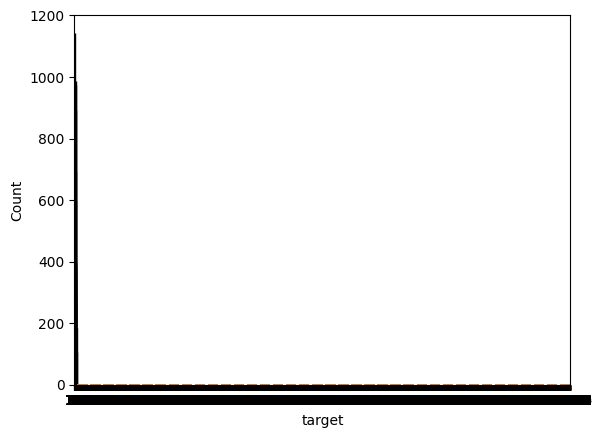

In [ ]:
import seaborn as sns
sns.countplot(raw_train_df['target']) #라벨의 분포 점검

In [65]:
raw_edge_index_df.duplicated(subset=['from', 'to']).sum() # 중복된 간선 수 확인

0

In [71]:
# 정규화 해야됨 (train,test 모두)
# 라벨의 분포가 극단적이니 보정을 고려해야됨

## 2. 그래프 구조 정의

* **그래프 객체 설계**:

  * `x` → 노드 feature tensor
  * `y` → 라벨 tensor
  * `edge_index` → \[2, num\_edges] 형태의 tensor
* **고민할 점**:

  * 엣지가 양방향이어야 하는지(undirected 변환 필요 여부).
  * self-loop(자기 자신 연결)을 추가해야 하는지.
  * train/test 노드를 어떻게 마스크할지(노드 분류 문제에서는 보통 데이터 전체를 그래프로 두고 일부 노드만 train으로 사용).

## 3. 데이터셋 분할 전략

* 보통 노드 분류는 **한 그래프 안에서 일부 노드만 학습**하고 나머지 노드에서 테스트합니다.
* **고민할 점**:

  * `train_mask`, `val_mask`, `test_mask`를 어떻게 정의할지.
  * train/test CSV로 나누어진 데이터라면, 이를 그래프에 어떻게 매핑할지.

## 4. GNN 모델 선택 및 설계

* **대표적인 선택지**:

  * **GCN (Graph Convolutional Network)**: 가장 기본적인 모델.
  * **GraphSAGE**: 이웃 샘플링 기반, 대규모 그래프에 유리.
  * **GAT (Graph Attention Network)**: attention으로 이웃 중요도 반영.
* **고민할 점**:

  * 어떤 모델이 내 데이터 특성(규모, feature sparsity, 라벨 수)에 적합할지.
  * 몇 개 레이어로 쌓을지.
  * hidden dimension 크기.
  * activation function.

## 5. 학습 세팅

* **필요 요소**:

  * Loss function → 분류 문제니까 `CrossEntropyLoss`가 일반적.
  * Optimizer → Adam, AdamW 등.
  * Learning rate, weight decay 등 하이퍼파라미터.
* **고민할 점**:

  * epoch 수를 얼마나 둘지.
  * early stopping 조건을 어떻게 둘지(Validation Accuracy 기준 등).

## 6. 모델 학습 & 평가

* 학습 루프:

  * forward → loss 계산 → backward → optimizer.step
* 평가:

  * Accuracy, F1-score 등 적절한 metric 선택.
* **고민할 점**:

  * imbalance 데이터라면 Accuracy 대신 Macro-F1 같은 지표도 봐야 할지.
  * train/val/test 성능 차이를 어떻게 해석할지.

## 7. 결과 해석 및 개선

* **분석 포인트**:

  * 어떤 노드에서 잘 맞추고, 어떤 노드에서 틀리는지.
  * feature importance / attention weight 등을 통해 모델 해석 가능성.
* **개선 방향**:

  * Feature engineering (새로운 node attribute 추가).
  * Edge augmentation (관계 추가).
  * 모델 구조 변경 (예: GAT → GraphSAGE).

## 8. (선택) 대규모 그래프 고려

* 만약 노드 수, 엣지 수가 매우 크다면:

  * Neighbor Sampling (GraphSAGE 스타일).
  * Mini-batch training.
  * Graph partitioning 기법.

## 보너스: 더 좋은 학습법 제안

* 지금 방식(직접 코드 작성 + 단계별 고민)은 아주 좋은 방법입니다.
* 다만 추가로 추천한다면:

  1. **실험 로그 기록**: 어떤 설정으로 학습했는지, 성능이 어떻게 나왔는지 기록하세요.
  2. **Baseline부터 시작**: 처음엔 GCN 2-layer + 작은 hidden\_dim으로 단순하게 시작.
  3. **점진적 확장**: baseline 결과를 확인한 뒤 GraphSAGE, GAT 등으로 확장.
  4. **이론 복습 병행**: 각 레이어 수식(GCN: mean aggregation, GAT: attention 계산)을 코드와 연결해 이해하면 더 빨리 체득됩니다.